# Rf 6 0 3_Multicpu

Likelihood and minimization: setting up a multi-core parallelized unbinned maximum likelihood fit




**Author:** Clemens Lange, Wouter Verkerke (C++ version)  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 02:58 AM.</small></i>

In [1]:
import ROOT

Welcome to JupyROOT 6.18/03


Create 3D pdf and data
-------------------------------------------

Create observables

In [2]:
x = ROOT.RooRealVar("x", "x", -5, 5)
y = ROOT.RooRealVar("y", "y", -5, 5)
z = ROOT.RooRealVar("z", "z", -5, 5)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Create signal pdf gauss(x)*gauss(y)*gauss(z)

In [3]:
gx = ROOT.RooGaussian(
    "gx", "gx", x, ROOT.RooFit.RooConst(0), ROOT.RooFit.RooConst(1))
gy = ROOT.RooGaussian(
    "gy", "gy", y, ROOT.RooFit.RooConst(0), ROOT.RooFit.RooConst(1))
gz = ROOT.RooGaussian(
    "gz", "gz", z, ROOT.RooFit.RooConst(0), ROOT.RooFit.RooConst(1))
sig = ROOT.RooProdPdf("sig", "sig", ROOT.RooArgList(gx, gy, gz))

Create background pdf poly(x)*poly(y)*poly(z)

In [4]:
px = ROOT.RooPolynomial("px", "px", x, ROOT.RooArgList(
    ROOT.RooFit.RooConst(-0.1), ROOT.RooFit.RooConst(0.004)))
py = ROOT.RooPolynomial("py", "py", y, ROOT.RooArgList(
    ROOT.RooFit.RooConst(0.1), ROOT.RooFit.RooConst(-0.004)))
pz = ROOT.RooPolynomial("pz", "pz", z)
bkg = ROOT.RooProdPdf("bkg", "bkg", ROOT.RooArgList(px, py, pz))

Create composite pdf sig+bkg

In [5]:
fsig = ROOT.RooRealVar("fsig", "signal fraction", 0.1, 0., 1.)
model = ROOT.RooAddPdf("model", "model", ROOT.RooArgList(
    sig, bkg), ROOT.RooArgList(fsig))

Generate large dataset

In [6]:
data = model.generate(ROOT.RooArgSet(x, y, z), 200000)

Parallel fitting
-------------------------------

In parallel mode the likelihood calculation is split in N pieces,
that are calculated in parallel and added a posteriori before passing
it back to MINUIT.

Use four processes and time results both in wall time and CPU time

In [7]:
model.fitTo(data, ROOT.RooFit.NumCPU(4), ROOT.RooFit.Timer(ROOT.kTRUE))

<ROOT.RooFitResult object at 0x(nil)>

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 4 remote server process.
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 fsig         1.00000e-01  5.00000e-02    0.00000e+00  1.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD         500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (sig,bkg)
[#1] INFO:Minization --  The following expressions have been identified as constant 

Parallel MC projections
----------------------------------------------

Construct signal, likelihood projection on (y,z) observables and
likelihood ratio

In [8]:
sigyz = sig.createProjection(ROOT.RooArgSet(x))
totyz = model.createProjection(ROOT.RooArgSet(x))
llratio_func = ROOT.RooFormulaVar(
    "llratio", "log10(@0)-log10(@1)", ROOT.RooArgList(sigyz, totyz))

Calculate likelihood ratio for each event, subset of events with high
signal likelihood

In [9]:
data.addColumn(llratio_func)
dataSel = data.reduce(ROOT.RooFit.Cut("llratio>0.7"))

Make plot frame and plot data

In [10]:
frame = x.frame(ROOT.RooFit.Title(
    "Projection on X with LLratio(y,z)>0.7"), ROOT.RooFit.Bins(40))
dataSel.plotOn(frame)

<ROOT.RooPlot object ("frame_x_563a6bbf3f10") at 0x563a6bbf3f10>

Perform parallel projection using MC integration of pdf using given input dataSet.
In self mode the data-weighted average of the pdf is calculated by splitting the
input dataset in N equal pieces and calculating in parallel the weighted average
one each subset. The N results of those calculations are then weighted into the
final result

Use four processes

In [11]:
model.plotOn(frame, ROOT.RooFit.ProjWData(dataSel), ROOT.RooFit.NumCPU(4))

c = ROOT.TCanvas("rf603_multicpu", "rf603_multicpu", 600, 600)
ROOT.gPad.SetLeftMargin(0.15)
frame.GetYaxis().SetTitleOffset(1.6)
frame.Draw()

c.SaveAs("rf603_multicpu.png")

[#1] INFO:Plotting -- RooAbsReal::plotOn(model) plot on x averages using data variables (y,z)
[#1] INFO:Plotting -- RooAbsReal::plotOn(model) only the following components of the projection data will be used: (y,z)
[#1] INFO:Plotting -- RooDataWeightedAverage::ctor(modelDataWgtAvg) constructing data weighted average of function model_Norm[x] over 14497 data points of (y,z) with a total weight of 14497
[#1] INFO:Plotting -- RooDataWeightedAverage::ctor(modelDataWgtAvg) constructing data weighted average of function model_Norm[x] over 14497 data points of (y,z) with a total weight of 14497
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 4 remote server process.
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (gy,gz,py,pz)
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (gy,gz,py,pz)
[#1] INFO:Minization --  The following expression

Info in <TCanvas::Print>: png file rf603_multicpu.png has been created


Draw all canvases 

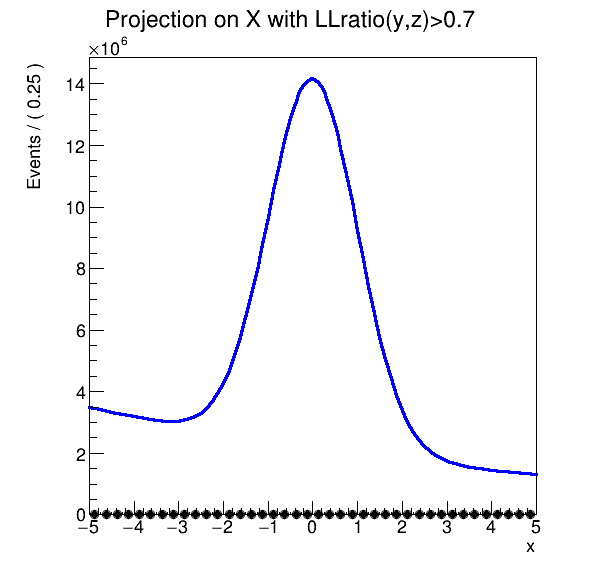

In [12]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()